#### Bibliotecas

In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
import os
import rasterio
from rasterio.mask import mask
from tqdm import tqdm
import networkx as nx
import itertools
import time
from geopy.distance import great_circle


#### Parâmetros

In [2]:
subprefeituras_shp = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp'
zonas_shp_OD_2023 = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/PESQUISA_ORIGEM_E_DESTINO_2023_anexos/002_Site Metro Mapas/Shape/Zonas_2023.shp'
verbose = True

# Diretórios e configurações
output_folder = r'/Volumes/MiniArmstro/Resultados'

#### Definindo os boundary boxes

In [5]:
# Carregar o arquivo CSV com as subprefeituras selecionadas
df_subprefeituras = pd.read_csv("resultados_ordenados_alagamentos.csv")

# Selecionar as 10 subprefeituras com maior índice de alagamento
df_sp_lista = df_subprefeituras.sort_values(by="Média", ascending=False).head(10)

# Carregar o shapefile das subprefeituras
gdf = gpd.read_file(subprefeituras_shp)

# Filtrar o GeoDataFrame para manter apenas as subprefeituras da lista
gdf_sp_filtrado = gdf[gdf["sp_nome"].isin(df_sp_lista["sp_nome"])]

# Salvar em disco (GeoPackage e Parquet)
#bbox_gdf.to_file("bounding_boxes.gpkg", driver="GPKG")
#bbox_gdf.to_parquet("bounding_boxes.parquet")

print("Bounding boxes geradas com sucesso!")

# Define the UTM Zone 23S coordinate system
utm_crs = CRS("EPSG:31983")  # UTM Zone 23S, southern hemisphere

# Atribuição do esquema de projeção
gdf_sp_filtrado = gdf_sp_filtrado.set_crs(utm_crs)

# Verificar o CRS atual
print("CRS Atual:", gdf_sp_filtrado.crs)

# Calcular a área em km²
gdf_sp_filtrado["Área_km2"] = (gdf_sp_filtrado.area / 1e6).round(2)  # Convertendo de m² para km²

# Exibir os 10 primeiros valores
gdf_sp_filtrado[["sp_nome", "Área_km2"]]


Bounding boxes geradas com sucesso!
CRS Atual: EPSG:31983


,sp_nome,Área_km2
1,CASA VERDE-CACHOEIRINHA,27.23
2,LAPA,40.64
4,SE,26.66
5,SANTANA-TUCURUVI,35.78
6,PINHEIROS,31.99
8,VILA MARIA-VILA GUILHERME,26.90
9,MOOCA,36.04
14,SAO MIGUEL,26.15
16,ARICANDUVA-FORMOSA-CARRAO,22.33
25,SANTO AMARO,37.74


In [6]:
# Explorar o mapa diretamente no Jupyter Notebook
gdf_sp_filtrado.explore(
    column="sp_nome",  # Colore cada bounding box de forma diferente
    cmap="Set1",  # Escolhe uma paleta de cores
    tooltip="sp_nome",  # Mostra o nome da subprefeitura ao passar o mouse
    popup=True,  # Exibe mais detalhes ao clicar
    tiles="CartoDB positron"  # Define o mapa base
)

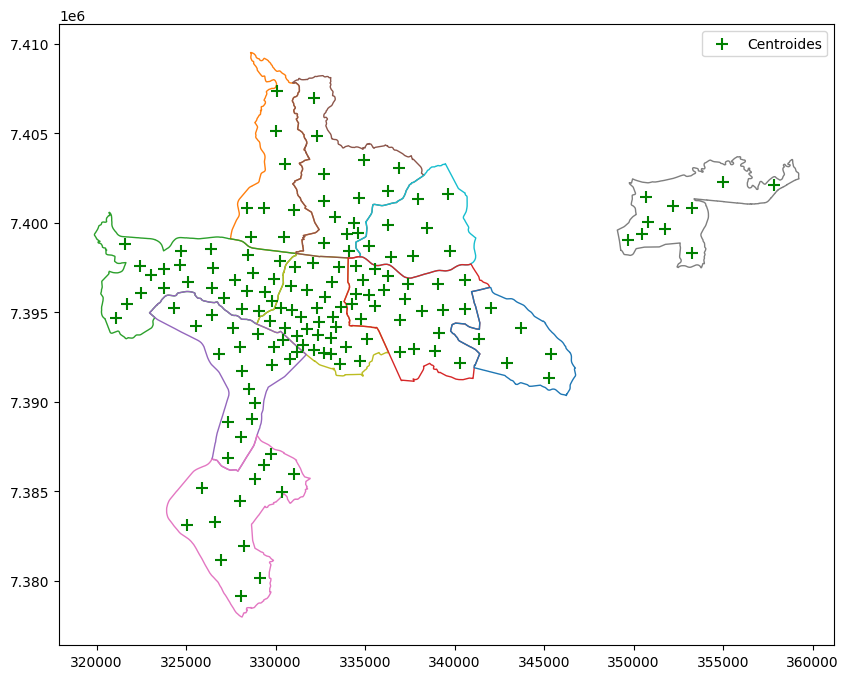

In [7]:
gdf_zonas_OD_2023 = gpd.read_file(zonas_shp_OD_2023)

# Atribuição do esquema de projeção
gdf_zonas_OD_2023_utm = gdf_zonas_OD_2023.to_crs(utm_crs)

# Filtrando para o munícipio de São Paulo
gdf_zonas_OD_SP_2023_utm = gdf_zonas_OD_2023_utm[gdf_zonas_OD_2023_utm['NomeMunici'] == 'São Paulo'].copy()

# Obtendo os centroides
gdf_zonas_OD_SP_2023_utm["centroid"] = gdf_zonas_OD_SP_2023_utm["geometry"].centroid

# Garantir que ambos os GeoDataFrames têm o mesmo CRS
gdf_zonas_OD_SP_2023_utm = gdf_zonas_OD_SP_2023_utm.to_crs(gdf_sp_filtrado.crs)

# Filtrar apenas os centroides que estão dentro das subprefeituras selecionadas
centroids = gdf_zonas_OD_SP_2023_utm['centroid']
centroids_filtrados = centroids[centroids.within(gdf_sp_filtrado.union_all())]

# Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar as subprefeituras
gdf_sp_filtrado.plot(ax=ax, column='sp_nome', facecolor='none', linewidth=1)

# Extraindo coordenadas dos centroides filtrados
x = centroids_filtrados.x
y = centroids_filtrados.y

# Plotar os centroides filtrados como estrelas (*)
ax.scatter(x, y, color='green', marker='+', s=70, label="Centroides")

# Adicionar legenda
ax.legend()

# Exibir o mapa
plt.show()

In [8]:
# Criar um GeoDataFrame apenas com os centroides
gdf_centroids = gpd.GeoDataFrame(geometry=gdf_zonas_OD_SP_2023_utm['centroid'], crs=gdf_sp_filtrado.crs)

# Fazer a junção espacial para associar centroides às subprefeituras
joined = gpd.sjoin(gdf_centroids, gdf_sp_filtrado, predicate='within', how='left')

# Contar quantos centroides existem por subprefeitura
centroid_counts = joined.groupby("sp_nome").size().reset_index(name="Num_Centroides")

# Exibir o resultado
print(centroid_counts)

                     sp_nome  Num_Centroides
0  ARICANDUVA-FORMOSA-CARRAO               6
1    CASA VERDE-CACHOEIRINHA               8
2                       LAPA              25
3                      MOOCA              23
4                  PINHEIROS              19
5           SANTANA-TUCURUVI              14
6                SANTO AMARO              13
7                 SAO MIGUEL              10
8                         SE              29
9  VILA MARIA-VILA GUILHERME               8


#### Extrair a rede viária

CRS atual do edges_baseline: epsg:4326
CRS do edges_baseline_reprojected: EPSG:31983
Grafo obtido com sucesso!


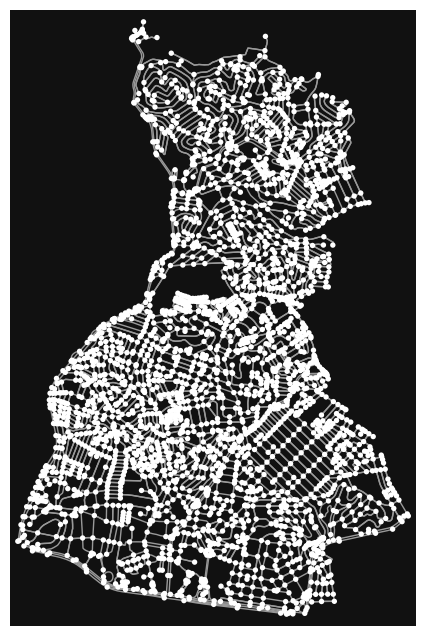

In [9]:
# Índice da subprefeitura
indice_sp = 0

# Verifica e define o CRS
if gdf_sp_filtrado.crs is None:
    gdf_sp_filtrado.set_crs(epsg=4326, inplace=True)  # Define como WGS 84 (latitude/longitude)

# Extrai a geometria
poligono = gdf_sp_filtrado.iloc[indice_sp].geometry

# Certifique-se de que o polígono está em EPSG:4326 (necessário para OSMNX)
if gdf_sp_filtrado.crs.to_epsg() != 4326:
    poligono = gdf_sp_filtrado.to_crs(epsg=4326).iloc[indice_sp].geometry

# Obtém o grafo
G_baseline = ox.graph_from_polygon(poligono, network_type="drive")
G_baseline = ox.routing.add_edge_speeds(G_baseline, fallback=50)  # Adiciona a velocidade dos eixos (km/h) ao grafo como o atributo do eixo speed_kph

node_baseline, edges_baseline = ox.graph_to_gdfs(G_baseline)

# Verificar o CRS atual
print("CRS atual do edges_baseline:", edges_baseline.crs)

# Reprojetar para EPSG:31983
edges_baseline_reprojected = edges_baseline.to_crs(epsg=31983)

# Verificar se a reprojeção foi bem-sucedida
print("CRS do edges_baseline_reprojected:", edges_baseline_reprojected.crs)

if verbose:
    print("Grafo obtido com sucesso!")
    ox.plot_graph(G_baseline)


#### Recortes dos raster em função dos boundary boxes

In [ ]:
# Somente executar este trecho uma única vez
# Carregar o GeoDataFrame das subprefeituras
gdf_sp = gdf_sp_filtrado

# Listar pacotes válidos
pacotes = [p for p in os.listdir(output_folder) if p.startswith("Pacote_") and p[-2:].isdigit()]

print(f"{len(pacotes)} pacotes identificados. Iniciando processamento...\n")

# Processamento
for pacote in tqdm(pacotes, desc="Processando Pacotes"):
    pacote_path = os.path.join(output_folder, pacote)
    simulacao_path = os.path.join(pacote_path, "Simulação")
    subprefeituras_path = os.path.join(pacote_path, "Sub-prefeituras")
    
    # Criar diretório de Subprefeituras se não existir
    os.makedirs(subprefeituras_path, exist_ok=True)
    
    # Filtrar subprefeituras dentro do pacote
    for _, subpref in tqdm(gdf_sp.iterrows(), total=len(gdf_sp), desc=f"Subprefeituras ({pacote})", leave=False):
        sp_nome = subpref["sp_nome"]
        sp_path = os.path.join(subprefeituras_path, sp_nome)
        os.makedirs(sp_path, exist_ok=True)
        
        # Verificar existência da pasta simulação
        if not os.path.exists(simulacao_path):
            print(f"[AVISO] Pasta 'simulação' não encontrada em {pacote}. Pulando...")
            continue
        
        # Processar arquivos .tif
        tif_files = [f for f in os.listdir(simulacao_path) if f.endswith(".tif") and not f.startswith("._")]
        for filename in tqdm(tif_files, desc=f"Clipando ({sp_nome})", leave=False):
            src_path = os.path.join(simulacao_path, filename)
            
            try:
                with rasterio.open(src_path) as src:
                    if gdf_sp.crs != src.crs:
                        gdf_sp = gdf_sp.to_crs(src.crs)
                    
                    sp_geometry = [subpref.geometry]
                    raster_bounds = box(*src.bounds)
                    if not raster_bounds.intersects(subpref.geometry):
                        print(f"[INFO] {filename} não sobrepõe {sp_nome}. Pulando...")
                        continue
                    
                    out_image, out_transform = mask(src, sp_geometry, crop=True)
                    out_meta = src.meta.copy()
                    out_meta.update({
                        "driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform,
                        "crs": src.crs
                    })
                    
                    output_filename = f"{os.path.splitext(filename)[0]}_{sp_nome}.tif"
                    output_path = os.path.join(sp_path, output_filename)
                    with rasterio.open(output_path, "w", **out_meta) as dest:
                        dest.write(out_image)
                    
                    #print(f"[SUCESSO] Arquivo clipado salvo: {output_path}")
            except Exception as e:
                print(f"[ERRO] Falha ao processar {filename}: {e}")

print("\nProcessamento concluído para todos os pacotes e subprefeituras!")

#### Funções de apoio

In [10]:
def adjust_speed_batch(row, raster_data, transform, threshold, threshold_max, speed_column):
    """
    Ajusta a velocidade de um segmento com base na profundidade do alagamento extraída de um raster.

    Parâmetros:
        row (GeoSeries): Linha atual do GeoDataFrame contendo informações de velocidade e geometria.
        raster_data (numpy.ndarray): Dados do raster contendo profundidade de alagamento.
        transform (Affine): Transformação do raster para coordenadas espaciais.
        threshold (float): Profundidade mínima para ajustar a velocidade.
        threshold_max (float): Profundidade máxima que torna a via intransitável.
        speed_column (str): Nome da coluna de referência para a velocidade original.
    
    Retorno:
        float: Velocidade ajustada para o segmento.
    """

    # Encontrar a coordenada do centro do segmento
    centroid = row.geometry.centroid

    # Transformar as coordenadas do centroide em índices do raster
    try:
        col_idx, row_idx = ~transform * (centroid.x, centroid.y) # Observe a ordem inversa
        row_idx, col_idx = int(row_idx), int(col_idx)
    except Exception:
        # Caso algo dê errado na transformação, manter a velocidade original
        #print('Mantive a velocidade que veio!')
        return row[speed_column]

    # Verificar se os índices estão dentro dos limites do raster
    if not (0 <= row_idx < raster_data.shape[0] and 0 <= col_idx < raster_data.shape[1]):
        print(row_idx, raster_data.shape[0], col_idx, raster_data.shape[1])
        return row[speed_column]
    
    # Extração do valor de profundidade do raster
    flood_depth = 1000*raster_data[row_idx, col_idx] # Valor extraído do raster em metros
    #print(flood_depth)

    # Ajustar a velocidade com base na profundidade
    if flood_depth > threshold_max:
        # Caso a altura exceda o limiar máximo, torna-se instransitável
        return 0
    elif flood_depth > threshold:
        # Aplicar a fórmula de ajuste da velocidade
        adjusted_speed = 0.0009 * (flood_depth ** 2) - 0.5529 * flood_depth + 86.9448
        #print('Pregnolato!')
        return min(adjusted_speed, row[speed_column])  # Garantir que não ultrapasse a velocidade original
        
    # Caso contrário, manter a velocidade original
    return row[speed_column]

In [13]:
def listar_atributos_arestas(G):
    atributos = set()
    for _, _, dados in G.edges(data=True):
        atributos.update(dados.keys())
    return atributos

# 1. Função para obter o número de viagens da matriz OD
def get_number_of_trips(node1, node2, referencia, od_matrix):
    zone1 = centroides_dentro.loc[centroides_dentro[referencia] == node1, 'NumeroZona'].values[0]
    zone2 = centroides_dentro.loc[centroides_dentro[referencia] == node2, 'NumeroZona'].values[0]
    return od_matrix.loc[zone1, zone2]

def tempo_medio_viagem(arquivo):

    # Filtrar os valores finitos para tempo com peso e num_viagens
    finite_mask_baseline = np.isfinite(arquivo['Tempo ponderado (min)'])
    finite_tempos_e_viagens_baseline = arquivo[finite_mask_baseline]

    # Calcular o número total de viagens sem valores infinitos
    total_trips_weighted = finite_tempos_e_viagens_baseline['Num_viagens'].sum()

    # Calcular o tempo total sem peso ignorando valores infinitos
    total_time_weighted = finite_tempos_e_viagens_baseline['Tempo ponderado (min)'].sum()

    # Calcular o tempo médio de viagem ponderado
    mean_time_weighted = total_time_weighted / total_trips_weighted

    # Exibir os resultados
    #print(f"Tempo médio de viagem com chuva e ponderado: {mean_time_weighted:.2f} minutos")

    return mean_time_weighted

#### Produzir novas referências de velocidade

In [ ]:
# Obter a lista de arquivos TIFF no diretório
arquivos_tif = [f for f in os.listdir(clipado_path) if f.endswith(".tif")]
total_arquivos = len(arquivos_tif)  # Total de arquivos a serem processados

# Função para extrair o número que aparece depois de "h_" ou "max_"
def extrair_numero(nome):
    match = re.search(r'(?:h_|max_)(\d+)', nome)  # Captura o número após "h_" ou "max_"
    return int(match.group(1)) if match else float('inf')  # Retorna um número grande se não encontrar nada

# Ordenar a lista com base no número extraído
arquivos_ordenados = sorted(arquivos_tif, key=extrair_numero)

# Exibir a lista ordenada
for arquivo in arquivos_ordenados:
    print(arquivo)

In [ ]:
# Verificar que as colunas não estão presentes no GDF
edges_baseline_reprojected.info()

In [ ]:
# Iterar sobre os arquivos clipados
for index, filename in enumerate(arquivos_ordenados, start=1):  # Começa em 1
    print(f"\nProcessando arquivo {index} de {total_arquivos}: {filename}")

    # Extrair informações do nome do arquivo
    match = re.search(r'pct(?P<pct>\d+)_h(?:_max)?_(?P<value>\d+)_clp', filename)
    if match:
        pct = match.group('pct')  # Valor após "pct"
        value = match.group('value')  # Valor numérico
        is_max = '_max' in filename  # Verificar se "max" está presente

        # Criar o nome da coluna dinamicamente
        column_suffix = f"pct{pct}_h_{value}" + ("_max" if is_max else "")
        column_name = column_suffix  # Exemplo: "pct1_h_2692800" ou "pct1_h_max_2768400"
        #print(f"Coluna gerada: {column_name}")

        # Caminho completo do arquivo raster
        raster_path = os.path.join(clipado_path, filename)

        # Abrir o raster e extrair os dados
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)  # Ler a primeira banda do raster
            raster_transform = src.transform

        # Aplicar a função de ajuste e criar uma nova coluna
        edges_baseline_reprojected[column_name] = edges_baseline_reprojected.apply(
            adjust_speed_batch,
            axis=1,
            args=(raster_data, raster_transform, threshold, threshold_max, 'speed_kph')
        )

print("\nProcessamento concluído!\n")

In [ ]:
# Verifique se as novas colunas foram adicionadas:
print(edges_baseline_reprojected.columns)

#### Calcular os tempos de viagem

In [ ]:
def add_edge_travel_times_gdf2(gdf, referencia):
    referencia_corrigida = referencia.replace('_clp.tif', '')  
    nome = 'tt_' + referencia_corrigida   
    
    # Criar a coluna apenas se não existir
    if nome not in gdf.columns:
        gdf[nome] = np.nan  

    # Garantir que as colunas existam e preencher valores NaN com 0
    if referencia_corrigida not in gdf.columns:
        gdf[referencia_corrigida] = 0  # Evita KeyError

    gdf['length'] = gdf.get('length', 0).fillna(0)

    # Criar máscara para vias intransitáveis
    intransitavel_mask = gdf[referencia_corrigida] == 0

    # Atribuir valores de tempo de viagem
    gdf.loc[intransitavel_mask, nome] = np.inf
    gdf.loc[~intransitavel_mask, nome] = (gdf.loc[~intransitavel_mask, 'length'] * 3.6) / gdf.loc[~intransitavel_mask, referencia_corrigida]

    return gdf

In [ ]:
# Aplicando a função para adicionar o tempo de viagem
data_batch = []
data = 0

for column_name in arquivos_ordenados:
    edges_simulados = add_edge_travel_times_gdf2(edges_baseline_reprojected, column_name)
    data_batch.append({
                    'index': data + 1,
                    'Referência': column_name.replace('_clp.tif', ''), # Remove "_clp.tif" da referência.
                })
    data += 1

edges_simulados = add_edge_travel_times_gdf2(edges_baseline_reprojected, 'speed_kph') # Essa linha é necessária para construir o baseline no arquivo GDF
data_batch.append({
    'index': data,
    'Referência': 'speed_kph',
})

# Criar DataFrame com os resultados
detalhes_arquivo_df = pd.DataFrame(data_batch)

# Criando a coluna "Max" com valor 0 por padrão
detalhes_arquivo_df["Max"] = 0

# Encontrar a linha que contém "max_"
linha_max = detalhes_arquivo_df[detalhes_arquivo_df["Referência"].str.contains("max_", na=False)]

if not linha_max.empty:
    # Extrair o número após "max_"
    match = re.search(r"max_(\d+)", linha_max["Referência"].values[0])
    
    if match:
        numero_max = match.group(1)  # Captura apenas o número após "max_"
        
        # Atualizar a linha correspondente ao número extraído, definindo "Max" como 1
        detalhes_arquivo_df.loc[detalhes_arquivo_df["Referência"].str.contains(f"h_{numero_max}", na=False), "Max"] = 1

# Remover a linha que contém "max_"
detalhes_arquivo_df = detalhes_arquivo_df[~detalhes_arquivo_df["Referência"].str.contains("max_", na=False)]

# Resetar o índice para manter organizado
detalhes_arquivo_df.reset_index(drop=True, inplace=True)

# Exibir o DataFrame atualizado
print(detalhes_arquivo_df)

In [ ]:
# Verifique se as novas colunas foram adicionadas:
print(edges_simulados.columns)

#### Construir um novo grafo, com todas referências de velocidades

In [ ]:
# Garantir que os nós tenham colunas 'x' e 'y' extraídas da geometria
#node_baseline["x"] = node_baseline.geometry.x
#node_baseline["y"] = node_baseline.geometry.y

# Gerar o grafo e armazená-lo no dicionário
G_dinamico = ox.graph_from_gdfs(node_baseline, edges_simulados)

# Exibir o grafo
print(G_dinamico)
ox.plot_graph(G_dinamico)

# Verificar o sistema de referência de coordenadas
crs = G_dinamico.graph['crs']
print(f'O sistema de referência de coordenadas do G_dinamico é:', crs)

In [ ]:
listar_atributos_arestas(G_dinamico)

In [ ]:
ox.save_graphml(G_dinamico, filepath='G_dinamico.graphml')

In [ ]:
# Verificar que os valores infinitos foram devidamente convertidos

# Nome da coluna de teste. Escolhi a max
coluna_alvo = "tt_pct1_h_2768400"

# Obter todas as arestas com seus atributos
dados_arestas = [data.get(coluna_alvo, np.nan) for _, _, data in G_dinamico.edges(data=True)]

# Contar quantos valores são infinitos
num_infinitos = np.isinf(dados_arestas).sum()

print(f"Número de valores infinitos em '{coluna_alvo}': {num_infinitos}")

#### Cálculo do caminho mínimo

In [ ]:
def pre_processar_grafo_star(G, referencia):
    """
    Pré-processa o grafo removendo arestas inválidas e identificando componentes conectados.
    """
    G_filtrado = G.copy()
    edges_remover = [(u, v, k) for u, v, k, d in G.edges(keys=True, data=True) if d.get(referencia, float('inf')) == float('inf')]
    G_filtrado.remove_edges_from(edges_remover)
    
    # Manter apenas a componente fortemente conectada maior
    componentes = list(nx.strongly_connected_components(G_filtrado))
    maior_componente = max(componentes, key=len)
    G_filtrado = G_filtrado.subgraph(maior_componente).copy()
    
    return G_filtrado

def heuristica_haversine(G, origem, destino):
    """
    Calcula a distância haversine entre dois nós do grafo.
    """
    lat1, lon1 = G.nodes[origem]['y'], G.nodes[origem]['x']
    lat2, lon2 = G.nodes[destino]['y'], G.nodes[destino]['x']
    return great_circle((lat1, lon1), (lat2, lon2)).meters

def caminho_minimo_star(G, origem, destino, peso):
    """
    Calcula o caminho mínimo entre dois nós no grafo pré-processado usando A*.
    """
    if not nx.has_path(G, origem, destino):
        return None, None
    
    try:
        caminho = nx.astar_path(G, source=origem, target=destino, weight=peso, heuristic=lambda u, v: heuristica_haversine(G, u, v))
        distancia = nx.astar_path_length(G, source=origem, target=destino, weight=peso, heuristic=lambda u, v: heuristica_haversine(G, u, v))
        return caminho, distancia
    except nx.NetworkXNoPath:
        return None, None

def calcula_caminho_minimo_star(gdf_OD, referencia_OD, G, referencia, sem_caminho=None):
    """
    Calcula caminhos mínimos entre pares de nós em um grafo OSMnx, considerando apenas vias transitáveis.
    """
    if sem_caminho is None:
        sem_caminho = set()
    
    G = pre_processar_grafo_star(G, referencia)  # Pré-processar grafo antes das buscas
    peso = referencia if any(referencia in d for _, _, d in G.edges(data=True)) else "length"
    
    nos_validos = set(G.nodes)  # Reduz buscas no grafo
    data_batch = []
    tempo_acumulado = 0 # Acumulador para o cálculo do tempo médio
    total_viagens = 0 # Contador de viagens
    start_time = time.time()
    
    for node1, node2 in itertools.combinations(gdf_OD[referencia_OD], 2):
        if node1 == node2 or (node1, node2) in sem_caminho or node1 not in nos_validos or node2 not in nos_validos:
            continue

        num_viagens = get_number_of_trips(node1, node2, referencia_OD, matriz_od_25)
        if num_viagens == 0:
            continue # Se não há viagens registradas, não processa
            
        caminho, tempo = caminho_minimo_star(G, node1, node2, peso)
        if caminho is not None:
            tempo_total = tempo * num_viagens  # Multiplica pelo número de viagens
            tempo_acumulado += tempo_total  # Acumula o tempo total
            total_viagens += num_viagens  # Acumula o número total de viagens
            
            data_batch.append({
                'Referência': referencia,
                'Origem': node1,
                'Destino': node2,
                'Tempo de viagem (min)': tempo / 60,
                'Número de viagens': num_viagens,
                'Tempo total ponderado (min)': tempo_total / 60,
                'Número de nós': len(caminho),
                'Percurso entre nós': list(caminho)
            })
        else:
            sem_caminho.add((node1, node2))

    tempo_medio = (tempo_acumulado / total_viagens) / 60 if total_viagens > 0 else None
    
    print(f"Tempo de processamento: {(time.time() - start_time) / 60:.2f} min")
    print(f'Viagens calculadas: {len(data_batch)}')
    print(f'Viagens sem conexão: {len(sem_caminho)}')
    print(f'Tempo médio de viagem ponderado: {tempo_medio:.2f} min' if tempo_medio else "Nenhuma viagem processada")
    
    return pd.DataFrame(data_batch), sem_caminho, tempo_medio


In [ ]:
atributos_tt = set()
    
for _, _, dados in G_dinamico.edges(data=True):
    for atributo in dados.keys():
        if atributo.startswith("tt"):
            atributos_tt.add(atributo)

atributos_tt = [linha for linha in atributos_tt if "speed"not in linha]

#Ordenar a lista pelo número extraído
atributos_tt_ord = sorted(atributos_tt, key=extrair_numero)

# Exibir a lista ordenada
for arquivo in atributos_tt_ord:
    print(arquivo)

# Limitando o tamanho da lista para facilitar o debug
atributos_tt_ord = atributos_tt_ord[6:7]
print(atributos_tt_ord)

In [ ]:
atributos_tt = set()
    
for _, _, dados in G_dinamico.edges(data=True):
    for atributo in dados.keys():
        if atributo.startswith("tt"):
            atributos_tt.add(atributo)

atributos_tt = [linha for linha in atributos_tt if "speed"not in linha]

#Ordenar a lista pelo número extraído
atributos_tt_ord = sorted(atributos_tt, key=extrair_numero)

# Exibir a lista ordenada
for arquivo in atributos_tt_ord:
    print(arquivo)

# Limitando o tamanho da lista para facilitar o debug
atributos_tt_ord = atributos_tt_ord[6:7]
print(atributos_tt_ord)

#### Montar o histograma

In [ ]:
df_resultados_resiliencia

# Remover a linha que contém "max" na coluna 'Hora Simulada'
resiliencia_df = df_resultados_resiliencia[~df_resultados_resiliencia['coluna'].str.contains('max', na=False)]

# Extrair o número após "h_" e converter para inteiro para ordenação
#resiliencia_df['h_value'] = resiliencia_df['Hora Simulada'].str.extract(r'h_(\d+)').astype(float)

# Ordenar o DataFrame pelo valor numérico extraído
resiliencia_df = resiliencia_df.sort_values(by='coluna', ascending=True)

# Resetar o índice após a ordenação
resiliencia_df = resiliencia_df.reset_index(drop=True)

# Exibir o DataFrame transformado
print(resiliencia_df)

In [ ]:
# Definir baseline como 'TT sem chuva, modificado'
baseline = resiliencia_df['tt_seco_mod'].min()
area_total = 0

# Criar figura
plt.figure(figsize=(10, 6))

# Criar índices para plotagem
x = np.arange(len(resiliencia_df))
y = resiliencia_df['tt_chuva'].values
baseline_values = resiliencia_df['tt_seco_mod'].values

# Plotar linha de TT com chuva
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Travel time, rain')

# Adicionar linha de baseline
plt.plot(x, baseline_values, linestyle='--', color='r', label='Travel time no rain, modified')

# Preencher trapézios entre baseline e TT com chuva
for i in range(len(x) - 1):
    x_trapezoid = [x[i], x[i], x[i+1], x[i+1]]
    y_trapezoid = [baseline_values[i], y[i], y[i+1], baseline_values[i]]

    # Preencher o trapézio
    plt.fill(x_trapezoid, y_trapezoid, 'gray', alpha=0.5, edgecolor='k', linewidth=1.5)

    # Calcular a área do trapézio
    base1 = abs(y[i] - baseline_values[i])
    base2 = abs(y[i+1] - baseline_values[i+1])
    altura = 1  # Como o eixo X é discreto, altura = 1 unidade
    area_trap = 0.5 * (base1 + base2) * altura
    area_total += area_trap

# Ajustes do gráfico
plt.xlabel('Hour')
plt.ylabel('Average Travel Time (min)')
plt.title('Average Travel Time Comparision, rain and no rain')
plt.legend()
plt.grid(True)

# Exibir gráfico
plt.show()

# Exibir área total sob a curva
print(f"A resiliência (área total sob a curva): {area_total:.2f} ")